In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from skimage.color import rgb2lab, lab2rgb
from skimage.io import imread, imshow
import keras.backend as K

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
BATCH_SIZE = 1
NUM_EPOCHS = 3
IMAGE_SIZE = (256, 256)

In [3]:
train_dir = './dataset/train'
train_dataset = image_dataset_from_directory(train_dir, label_mode=None, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)

validation_dir = './dataset/validation'
validation_dataset = image_dataset_from_directory(validation_dir, label_mode=None, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)

test_dir = './dataset/test'
test_dataset = image_dataset_from_directory(test_dir, label_mode=None, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)

Found 21 files belonging to 1 classes.
Found 21 files belonging to 1 classes.
Found 21 files belonging to 1 classes.


(1, 256, 256, 3)


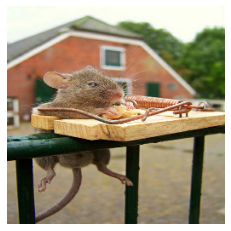

In [4]:
for images in train_dataset.take(1):
    print(images.shape)
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.axis("off")

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:
from model import Unet
model = Unet().model()

In [7]:
# test if preprocess is fine
for image_batch in train_dataset.take(1):
    l, ab = preprocess_images_batch(image_batch)
    print(np.amin(ab), np.amax(ab))

    a = ab[0,:,:,0] * 128
    l = l[0,:,:,0] * 100
    b = ab[0,:,:,1] * 128

    only_l = np.dstack((l, np.zeros(l.shape), np.zeros(l.shape)))
    ab = np.dstack((np.zeros(l.shape), a, b))  # doesn't make much sense as an image

    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
    imshow(lab2rgb(only_l), ax=ax0), ax0.set_title('Only L'), ax0.axis('off')
    imshow(lab2rgb(ab), ax=ax1), ax1.set_title('AB'), ax1.axis('off'),
    imshow(lab2rgb(np.dstack((l, np.dstack((a, b))))), ax=ax2), ax2.set_title('Concatenated image'), ax2.axis('off')
    plt.show()

NameError: name 'preprocess_images_batch' is not defined

In [8]:
delta = 1
def l_delta_loss(y_true, y_pred):
    smaller = K.cast(K.abs(y_true - y_pred) < delta, tf.float32)
    bigger = 1 - smaller
    loss = K.sum(smaller * K.square(y_true - y_pred)) / 2 + delta * K.sum((K.abs(y_true - y_pred) - (delta / 2)))
    return loss

In [9]:
base_learning_rate = 0.0001
model.compile(loss=l_delta_loss,
              optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bw_conv1_1 (Conv2D)             (None, 256, 256, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
ab_conv1_1 (Conv2D)             (None, 256, 256, 64) 1792        input_1[0][0]                    
_______________________________________________________________________________________

In [11]:
from utils.data_generator import DataGenerator

In [12]:
train_generator = DataGenerator(batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, image_dataset=train_dataset, shuffle=True)
validation_generator = DataGenerator(batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, image_dataset=validation_dataset)

Initialized
Initialized


In [13]:
train_generator.__len__()
train_generator.__getitem__(0)

0


([array([[[[0.7723392 ],
           [0.7829066 ],
           [0.7762144 ],
           ...,
           [0.8608311 ],
           [0.8594606 ],
           [0.8591161 ]],
  
          [[0.7800636 ],
           [0.7755877 ],
           [0.7771849 ],
           ...,
           [0.86337847],
           [0.8653233 ],
           [0.8731854 ]],
  
          [[0.7774256 ],
           [0.7751037 ],
           [0.77820617],
           ...,
           [0.8747395 ],
           [0.8739383 ],
           [0.8763389 ]],
  
          ...,
  
          [[0.89036727],
           [0.8825322 ],
           [0.8711773 ],
           ...,
           [0.9625322 ],
           [0.9594966 ],
           [0.9718795 ]],
  
          [[0.8951052 ],
           [0.8806804 ],
           [0.8676287 ],
           ...,
           [0.95223886],
           [0.9726864 ],
           [0.9680631 ]],
  
          [[0.85341215],
           [0.8528867 ],
           [0.86020577],
           ...,
           [0.9685198 ],
           [0.96

In [14]:
history = model.fit(train_generator, epochs=NUM_EPOCHS, validation_data=validation_generator)

0
Epoch 1/3
10
18
13/21 [=================>............] - ETA: 39s - loss: -44179.8945 - accuracy: 0.42138


KeyboardInterrupt: 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('L-delta Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()